# CS 675 Machine Learning
# Human Protein Atlas - Single Cell Classification
# Find individual human cell differences in microscope images
# Advanced models: choose 1 from XGBoost W12 or Neural Network W13 or Deep learning W14 to build your supervised learning models
# Team Members are pr454(Preethi Ravulapally), sk2924(Kopparapu Sai Venkat Krishna) and pb536(Pooja Reddy Banala)

In [1]:

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.models as models
from sklearn.metrics import f1_score
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, random_split, DataLoader

%matplotlib inline


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/train.csv")
dataset.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


### There are in total 19 different labels present in the dataset
### All image samples are represented by four filters (stored as individual files), the protein of interest (green) plus three cellular landmarks: nucleus (blue), microtubules (red), endoplasmic reticulum (yellow). The green filter should hence be used to predict the label, and the other filters are used as references. The labels are represented as integers that map to the following:

In [ ]:
labels = {
    0:'Nucleoplasm',
1:'Nuclear membrane',
2:'Nucleoli',
3:'Nucleoli fibrillar center',
4:'Nuclear speckles',
5:'Nuclear bodies',
6:'Endoplasmic reticulum',
7:'Golgi apparatus',
8:'Intermediate filaments',
9:'Actin filaments',
10:'Microtubules',
11:'Mitotic spindle',
12:'Centrosome',
13:'Plasma membrane',
14:'Mitochondria',
15:'Aggresome',
16:'Cytosol',
17:'Vesicles and punctate cytosolic patterns',
18:'Negative'
}

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path

img_size = 256

classes = ["Nucleoplasm", "Nuclear Membrane", "Nucleoli", "Nucleoli Fibrillar Center", "Nuclear Speckles", "Nuclear Bodies", "Endoplasmic Reticulum", "Golgi Apparatus", "Intermediate Filaments", "Actin Filaments", "Microtubules", "Mitotic Spindle", "Centrosome", "Plasma Membrane", "Mitochondria", "Aggresome", "Cytosol", "Vesicles", "Negative"]
class2idx = {i :cls for i,cls in enumerate(classes)}
idx2class = {cls:i  for i,cls in enumerate(classes)}

# path = data
path = Path('.')
def get_x(row):
    ID = row["ID"]
    r = np.array(Image.open(path/'home'/(ID + "_red.png")))
    g = np.array(Image.open(path/'home'/(ID + "_green.png")))
    b = np.array(Image.open(path/'home'/(ID + "_blue.png")))
    rgb = Image.fromarray(np.dstack([r, g, b])).resize((img_size, img_size)).save('hpa-256/' + ID + ".png")

df = pd.read_csv('/content/drive/MyDrive/train.csv')

# df.apply(get_x, axis = 1) # Run if you dont have the resized Data

for i in range(len(classes)):
    df[f'{i}'] =0

for i in range(df.shape[0]):
    a = df.loc[i,'Label'].split('|')
    a_len = len(df.loc[i,'Label'].split('|'))
    for j in range(a_len ):
        df.loc[i,a[j]] = 1
print(df)

                                         ID  Label  0  1  2  ...  14  15  16  17  18
0      5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0  1  0  0  ...   0   0   0   0   0
1      5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0  1  0  0  ...   1   0   0   0   0
2      60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1  0  1  0  ...   0   0   0   0   0
3      5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10  0  0  0  ...   0   0   1   0   0
4      5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0  1  0  0  ...   1   0   0   0   0
...                                     ...    ... .. .. ..  ...  ..  ..  ..  ..  ..
21801  dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0     14  0  0  0  ...   1   0   0   0   0
21802  dd1f7fb8-bbca-11e8-b2bc-ac1f6b6435d0    3|0  1  0  0  ...   0   0   0   0   0
21803  dd5cb36a-bbca-11e8-b2bc-ac1f6b6435d0   14|0  1  0  0  ...   1   0   0   0   0
21804  df573730-bbca-11e8-b2bc-ac1f6b6435d0     14  0  0  0  ...   1   0   0   0   0
21805  dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0    5|0  1  0  0  ... 

In [ ]:
df.drop(['Label'],axis=1).to_csv('/content/train_cleaned.csv',index=False)


In [ ]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        # print(row)
        img_id, img_label = row['ID'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #stats that were used to pretrained the original network, values should be maintained


train_tfms = T.Compose([
    T.RandomCrop(272, padding=8, padding_mode='reflect'), #Random cropping, padding mode reflect or simmetric?
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.RandomVerticalFlip(),
    # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), #random brightness, contrast and saturation changes, maybe?
    T.ToTensor(), 
    T.Normalize(*imagenet_stats,inplace=True), # data normalization
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.ToTensor(), 
    T.Normalize(*imagenet_stats)
])

In [ ]:
np.random.seed(123)
msk = np.random.rand(len(dataset)) < 0.8
train_df = dataset[msk].reset_index()
val_df = dataset[~msk].reset_index()
len(train_df),len(val_df)


(17480, 4326)

In [ ]:
def show_sample(img, target, invert=True):
    # print(img)
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0),cmap='viridis')
    print('Labels:', decode_target(target, text_labels=True))

In [ ]:
def encode_label(label):
    target = torch.zeros(19)
    for l in str(label).split('|'):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: Nuclear speckles(4)


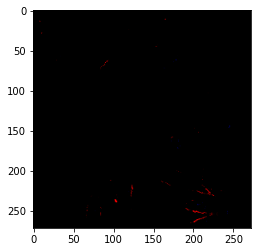

In [ ]:
show_sample(*train_ds[151],invert=False)


In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [ ]:
class ProteinResnet34(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 19)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

# Model Resnet34

In [ ]:
model = ProteinResnet34()
model

ProteinResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([64, 3, 272, 272])
out.shape: torch.Size([64, 19])
out[0]: tensor([0.3762, 0.3722, 0.6326, 0.7493, 0.6797, 0.5797, 0.7324, 0.5487, 0.6857,
        0.3361, 0.3787, 0.4042, 0.2548, 0.4339, 0.3756, 0.7110, 0.2421, 0.3135,
        0.5605], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ProteinResnet34(), device)

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.7258304357528687, 'val_score': 0.1314009577035904}]

In [ ]:
model.freeze()
epochs = 7
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

### Below are the results stating the epochs, train_loss, val_loss and val_score

In [ ]:
from tqdm.notebook import tqdm
%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], last_lr: 0.0048, train_loss: 0.2247, val_loss: 0.2549, val_score: 0.2410



Epoch [1], last_lr: 0.0099, train_loss: 0.2265, val_loss: 0.2518, val_score: 0.1432



Epoch [2], last_lr: 0.0092, train_loss: 0.2226, val_loss: 0.2173, val_score: 0.2605



Epoch [3], last_lr: 0.0067, train_loss: 0.2167, val_loss: 0.2175, val_score: 0.2531



Epoch [4], last_lr: 0.0036, train_loss: 0.2100, val_loss: 0.2361, val_score: 0.3092



Epoch [5], last_lr: 0.0010, train_loss: 0.2032, val_loss: 0.2242, val_score: 0.2901



Epoch [6], last_lr: 0.0000, train_loss: 0.1970, val_loss: 0.1935, val_score: 0.3633


In [ ]:
model.unfreeze()
epochs = 5
max_lr = 0.001

In [ ]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], last_lr: 0.0008, train_loss: 0.1954, val_loss: 0.1961, val_score: 0.4024



Epoch [1], last_lr: 0.0010, train_loss: 0.1941, val_loss: 0.2153, val_score: 0.3543



Epoch [2], last_lr: 0.0006, train_loss: 0.1909, val_loss: 0.1868, val_score: 0.3988



Epoch [3], last_lr: 0.0002, train_loss: 0.1871, val_loss: 0.1824, val_score: 0.4521



Epoch [4], last_lr: 0.0000, train_loss: 0.1839, val_loss: 0.1804, val_score: 0.4518
CPU times: user 4min 37s, sys: 4min 20s, total: 8min 58s
Wall time: 12min 46s


In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
test_df = pd.read_csv("/content/train.csv")
test_dataset = HumanProteinDataset(test_df, "/content/Test", transform=valid_tfms)
# print(test_dataset)

In [ ]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 256, 256])

### Predicting a sample for which lable the image belongs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                                     ID  Label
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0
1  5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0
2  60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1
3  5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10
4  5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0
Prediction:  tensor([0.0138, 0.0087, 0.0110, 0.0058, 0.0070, 0.0111, 0.2576, 0.0135, 0.1304,
        0.0103, 0.6049, 0.0105, 0.0402, 0.1042, 0.0156, 0.0048, 0.5033, 0.0089,
        0.0018], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Microtubules(10) Cytosol(16)


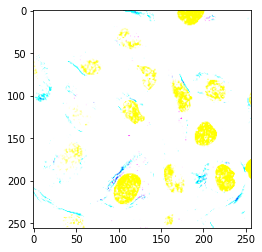

In [ ]:
print(test_df.head())
predict_single(test_dataset[3][0])

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)

In [ ]:
test_preds.to_csv("submission.csv", index=False)